<a href="https://colab.research.google.com/github/Minupama/PatternRecognition_Assignment/blob/main/DenseNet_defungi_210338F.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Step 1: Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
# Step 2: Import Libraries
import os
import random
import shutil
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator



In [ ]:
# Step 3: Set Up Dataset Path and Splitting Function
data_dir = '/content/drive/My Drive/defungi'  # Path to your dataset
output_dir = '/content/defungi_split'

In [ ]:
# Create train/test/validation splits
def split_dataset(data_dir, output_dir, train_ratio=0.6, test_ratio=0.2, val_ratio=0.2):
    if os.path.exists(output_dir):
        shutil.rmtree(output_dir)
    os.makedirs(output_dir, exist_ok=True)

    for class_folder in os.listdir(data_dir):
        class_path = os.path.join(data_dir, class_folder)
        if not os.path.isdir(class_path):
            continue

        images = os.listdir(class_path)
        random.shuffle(images)

        train_split = int(len(images) * train_ratio)
        test_split = int(len(images) * (train_ratio + test_ratio))

        splits = {
            'train': images[:train_split],
            'test': images[train_split:test_split],
            'val': images[test_split:]
        }

        for split, split_images in splits.items():
            split_dir = os.path.join(output_dir, split, class_folder)
            os.makedirs(split_dir, exist_ok=True)
            for img in split_images:
                shutil.copy(os.path.join(class_path, img), os.path.join(split_dir, img))


In [ ]:
# Split the dataset
split_dataset(data_dir, output_dir)

In [ ]:

# Step 4: Create Data Generators
train_dir = os.path.join(output_dir, 'train')
test_dir = os.path.join(output_dir, 'test')
val_dir = os.path.join(output_dir, 'val')

In [ ]:
image_size = (224, 224)  # Image size for AlexNet
batch_size = 32


In [ ]:

train_datagen = ImageDataGenerator(rescale=1.0/255.0, horizontal_flip=True, rotation_range=20)
test_val_datagen = ImageDataGenerator(rescale=1.0/255.0)



In [ ]:
# Set up ImageDataGenerator with validation split (20%)
train_datagen = ImageDataGenerator(
    rescale=1.0/255.0,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.2  # 20% of data will be used for validation
)


# Create train generator (60% training)
train_generator = train_datagen.flow_from_directory(
    data_dir,
    target_size=image_size,
    batch_size=batch_size,
    subset="training",  # 60% for training
    class_mode="categorical"
)

Found 6761 images belonging to 5 classes.


In [ ]:
# Create validation generator (20% validation)
val_generator = train_datagen.flow_from_directory(
    data_dir,
    target_size=image_size,
    batch_size=batch_size,
    subset="validation",  # 20% for validation
    class_mode="categorical"
)

Found 1686 images belonging to 5 classes.


In [ ]:
# Set up a separate ImageDataGenerator for test data (the other 20% of data)
test_datagen = ImageDataGenerator(rescale=1.0/255.0)

# Create the test generator using the remaining data directory
test_generator = test_datagen.flow_from_directory(
    data_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode="categorical"
)

Found 8447 images belonging to 5 classes.


In [ ]:
# Load the DenseNet model, pre-trained on ImageNet
base_model = tf.keras.applications.DenseNet121(
    weights='imagenet',
    include_top=False,
    input_shape=image_size + (3,)
)


29084464/29084464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
# Freeze the base model layers to use it for transfer learning
base_model.trainable = False

# Add custom layers on top of DenseNet
x = base_model.output
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dropout(0.5)(x)
x = tf.keras.layers.Dense(256, activation='relu')(x)
x = tf.keras.layers.Dropout(0.5)(x)
predictions = tf.keras.layers.Dense(train_generator.num_classes, activation='softmax')(x)

# Create the final model
model = tf.keras.Model(inputs=base_model.input, outputs=predictions)

# Compile the model
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Train the model
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=20,

)

Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


212/212 ━━━━━━━━━━━━━━━━━━━━ 194s 771ms/step - accuracy: 0.3748 - loss: 1.6071 - val_accuracy: 0.5771 - val_loss: 1.0691
Epoch 2/20
212/212 ━━━━━━━━━━━━━━━━━━━━ 136s 622ms/step - accuracy: 0.5208 - loss: 1.1762 - val_accuracy: 0.5919 - val_loss: 1.0197
Epoch 3/20
212/212 ━━━━━━━━━━━━━━━━━━━━ 142s 626ms/step - accuracy: 0.5485 - loss: 1.0965 - val_accuracy: 0.5836 - val_loss: 1.0356
Epoch 4/20
212/212 ━━━━━━━━━━━━━━━━━━━━ 136s 628ms/step - accuracy: 0.5691 - loss: 1.0416 - val_accuracy: 0.5896 - val_loss: 0.9990
Epoch 5/20
212/212 ━━━━━━━━━━━━━━━━━━━━ 157s 696ms/step - accuracy: 0.5716 - loss: 1.0085 - val_accuracy: 0.5955 - val_loss: 0.9922
Epoch 6/20
212/212 ━━━━━━━━━━━━━━━━━━━━ 186s 620ms/step - accuracy: 0.5820 - loss: 1.0016 - val_accuracy: 0.5979 - val_loss: 0.9797
Epoch 7/20
212/212 ━━━━━━━━━━━━━━━━━━━━ 136s 629ms/step - accuracy: 0.5817 - loss: 0.9764 - val_accuracy: 0.5913 - val_loss: 0.9889
Epoch 8/20
212/212 ━━━━━━━━━━━━━━━━━━━━ 136s 620ms/step - accuracy: 0.5964 - loss: 0.95

In [ ]:
import os
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import numpy as np

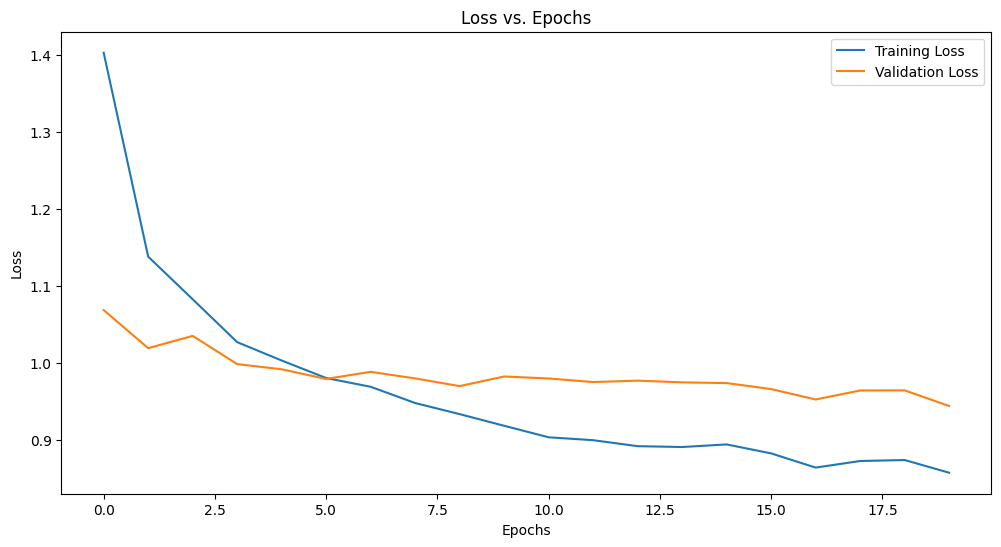

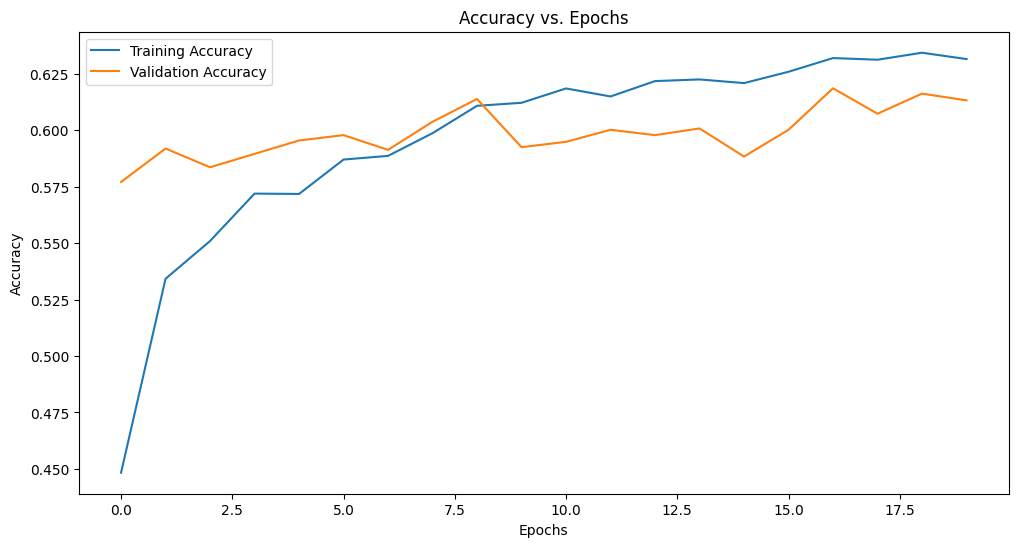

In [ ]:
#Plot Training and Validation Metrics
def plot_metrics(history):
    # Plot Loss
    plt.figure(figsize=(12, 6))
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Loss vs. Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    # Plot Accuracy
    plt.figure(figsize=(12, 6))
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Accuracy vs. Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

plot_metrics(history)

In [ ]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix

# Get true labels from the test generator
y_true = test_generator.classes

# Get predicted probabilities
y_pred_prob = model.predict(test_generator, verbose=1)

# Convert predicted probabilities to class indices
y_pred = np.argmax(y_pred_prob, axis=1)






/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


264/264 ━━━━━━━━━━━━━━━━━━━━ 68s 212ms/step


In [ ]:
# Get the class labels
class_labels = list(test_generator.class_indices.keys())



# Generate a confusion matrix
print("Confusion Matrix:")
print(confusion_matrix(y_true, y_pred))


Confusion Matrix:
[[3463  391  154   48  358]
 [1811  242   86   27  168]
 [ 630   77   38   13   61]
 [ 116   13    5    0    7]
 [ 580   65   25    3   66]]


In [ ]:
# Classification Report
report = classification_report(y_true, y_pred, target_names=test_generator.class_indices.keys())
print("Classification Report:")
print(report)



Classification Report:
              precision    recall  f1-score   support

          H1       0.52      0.78      0.63      4414
          H2       0.31      0.10      0.16      2334
          H3       0.12      0.05      0.07       819
          H5       0.00      0.00      0.00       141
          H6       0.10      0.09      0.09       739

    accuracy                           0.45      8447
   macro avg       0.21      0.20      0.19      8447
weighted avg       0.38      0.45      0.39      8447



Confusion Matrix:
[[3463  391  154   48  358]
 [1811  242   86   27  168]
 [ 630   77   38   13   61]
 [ 116   13    5    0    7]
 [ 580   65   25    3   66]]


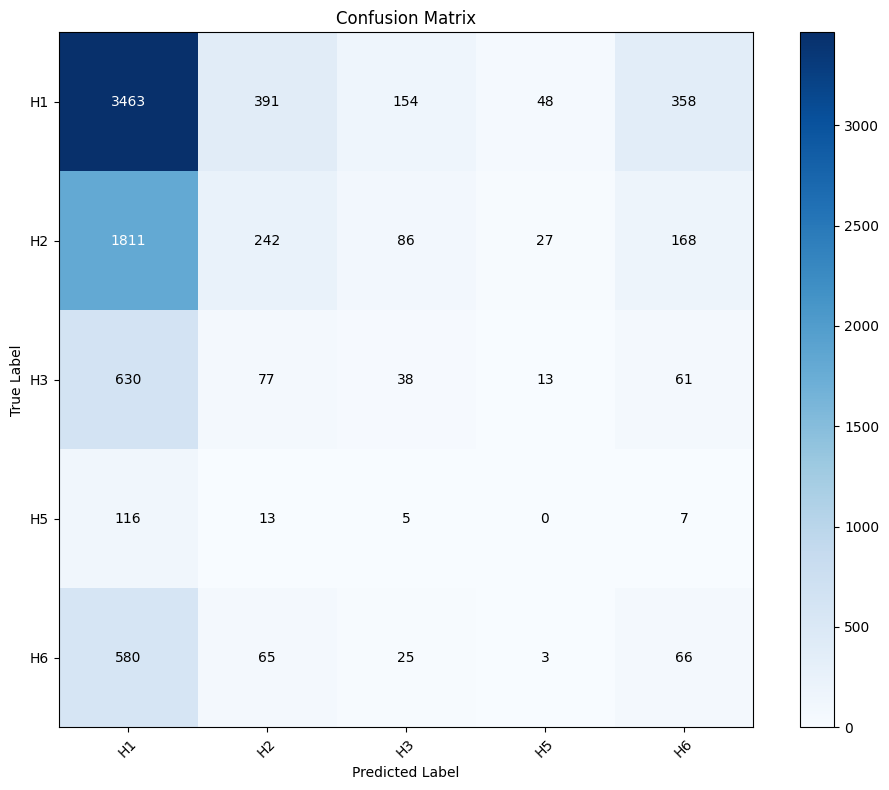

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix

# Confusion Matrix
conf_matrix = confusion_matrix(y_true, y_pred)
print("Confusion Matrix:")
print(conf_matrix)

# Plot Confusion Matrix with Values
plt.figure(figsize=(10, 8))
plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()

# Add labels
tick_marks = np.arange(len(test_generator.class_indices))
class_labels = list(test_generator.class_indices.keys())
plt.xticks(tick_marks, class_labels, rotation=45)
plt.yticks(tick_marks, class_labels)

# Annotate cells with values
thresh = conf_matrix.max() / 2.0  # Set threshold for text color
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        plt.text(
            j, i, format(conf_matrix[i, j], 'd'),
            ha="center", va="center",
            color="white" if conf_matrix[i, j] > thresh else "black"
        )

plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.show()
